<a href="https://colab.research.google.com/github/sourcecode369/deep-nlp/blob/master/machine%20translation/Sequence_to_Sequence_Models_for_Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, print_function, unicode_literals, division
from builtins import input, range

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import urllib

TensorFlow 2.x selected.


In [3]:
try:
  print("Uploading...")
  from google.colab import files
  files.upload()
  print("File uploaded successfully.")
except Exception as ex:
  print(ex)

Uploading...


Saving spa-eng.zip to spa-eng.zip
File uploaded successfully.


In [4]:
import zipfile
with zipfile.ZipFile("spa-eng.zip",mode='r') as zf:
  zf.printdir() 
  print('Extracting all the files now...') 
  zf.extractall()
  print('Done!')
!ls -GFlash --color

File Name                                             Modified             Size
_about.txt                                     2020-01-11 23:49:12         1441
spa.txt                                        2020-01-11 23:49:12     18432706
Extracting all the files now...
Done!
total 23M
4.0K drwxr-xr-x 1 root 4.0K Jan 26 17:10 ./
4.0K drwxr-xr-x 1 root 4.0K Jan 26 17:01 ../
4.0K -rw-r--r-- 1 root 1.5K Jan 26 17:10 _about.txt
4.0K drwxr-xr-x 1 root 4.0K Jan 13 16:38 .config/
4.0K drwxr-xr-x 1 root 4.0K Jan 13 16:38 sample_data/
4.6M -rw-r--r-- 1 root 4.6M Jan 26 17:05 spa-eng.zip
 18M -rw-r--r-- 1 root  18M Jan 26 17:10 spa.txt


In [5]:
with open('spa.txt',mode='rb') as t:
  print(t.read(200))

b'Go.\tVe.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)\nGo.\tVete.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)\nGo.\tVaya.\tCC-BY 2.0 '


In [0]:
%tensorflow_version 2.x
import os, sys
import gc
gc.enable()

import numpy as np 
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")


In [0]:
# BATCH_SIZE = 64
# BATCH_SIZE = 128
BATCH_SIZE = 256
# BATCH_SIZE = 512

EPOCHS = 100

# LATENT_DIM = 512
LATENT_DIM = 1024
# LATENT_DIM = 2056

NUM_SAMPLES = 10000
MAX_SEQUENCE_LEGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 50

In [0]:
input_texts = []
target_texts = []
target_texts_inputs = []

In [9]:
#load in the data
t = 0
for line in open('spa.txt'):
  t+= 1
  if t>NUM_SAMPLES:
    print('Max Samples Exceeded. Breaking out of loop.')
    break
  if '\t' not in line:
    continue
  input_text, translation = line.split('\t')[:-1]
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation 

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples: ",len(input_texts))

Max Samples Exceeded. Breaking out of loop.
num samples:  10000


In [0]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [11]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.'% len(word2idx_inputs))

Found 2352 unique input tokens.


In [0]:
max_len_input = max(len(x) for x in input_sequences)

In [0]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [14]:
word2idx_outputs = tokenizer_outputs.word_index 
print('Found %s unique output tokens.'%len(word2idx_outputs))

Found 4981 unique output tokens.


In [0]:
num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)

In [16]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print('encoder_data.shape',encoder_inputs)
print('encoder_data.shape[0]',encoder_inputs[0])

encoder_data.shape [[   0    0    0    0   13]
 [   0    0    0    0   13]
 [   0    0    0    0   13]
 ...
 [   0    0  459    2   55]
 [   0    0  459   20  114]
 [   0    0  459   20 1414]]
encoder_data.shape[0] [ 0  0  0  0 13]


In [17]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target)
print('decoder_data.shape',decoder_inputs.shape)
print('decoder_data',decoder_inputs[0])

decoder_data.shape (10000, 9)
decoder_data [ 0  0  0  0  0  0  0  1 67]


In [0]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

In [19]:
import urllib
print('Downloading pretrained embedding vectors..')
urllib.request.urlretrieve("https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz",filename="glove.6B.50d.txt.gz")

print('Extracting pretrained embedding vectors...')
import gzip
import shutil
with gzip.open('glove.6B.50d.txt.gz', 'rb') as f_in:
    with open('glove.6B.50d.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print('Loading pretrained embedding...')
word2vec = {}
with open('glove.6B.50d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print(f"Found {len(word2vec)} word vectors")

print('Filling pretrained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector      
print('Done.!')

embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_len_input)

Extracting pretrained embedding vectors...
Loading pretrained embedding...
Found 400000 word vectors
Filling pretrained embeddings...
Done.!


In [0]:
decoder_targets_one_hot = np.zeros((len(input_texts), max_len_target, num_words_output), dtype='float32')

In [0]:
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [0]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True,   dropout=0.5)
encoder_outputs, h, c = encoder(x)

encoder_states = [h, c]

decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True,dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs_x,
    initial_state = encoder_states
)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

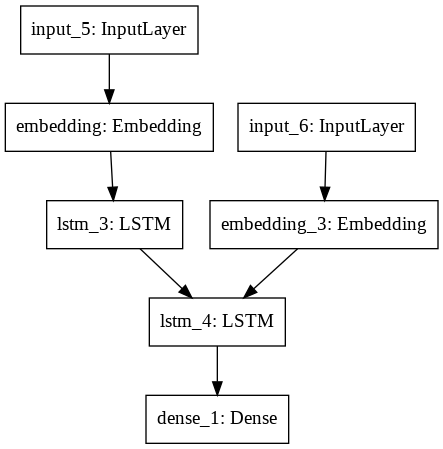

In [25]:
tf.keras.utils.plot_model(model)

In [34]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 50)        117650      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 9, 1024)      5101568     input_8[0][0]                    
____________________________________________________________________________________________

In [35]:
r = model.fit([encoder_inputs, decoder_inputs], decoder_targets_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='min',restore_best_weights=True)])

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 8s 979us/sample - loss: 3.2840 - accuracy: 0.5859 - val_loss: 2.8366 - val_accuracy: 0.5858
Epoch 2/100
8000/8000 [==============================] - 5s 649us/sample - loss: 2.2444 - accuracy: 0.6584 - val_loss: 2.7878 - val_accuracy: 0.5924
Epoch 3/100
8000/8000 [==============================] - 5s 644us/sample - loss: 2.0847 - accuracy: 0.6737 - val_loss: 2.5881 - val_accuracy: 0.6118
Epoch 4/100
8000/8000 [==============================] - 5s 651us/sample - loss: 1.9029 - accuracy: 0.6945 - val_loss: 2.4260 - val_accuracy: 0.6559
Epoch 5/100
8000/8000 [==============================] - 5s 641us/sample - loss: 1.7283 - accuracy: 0.7148 - val_loss: 2.3147 - val_accuracy: 0.6744
Epoch 6/100
8000/8000 [==============================] - 5s 649us/sample - loss: 1.5838 - accuracy: 0.7247 - val_loss: 2.2656 - val_accuracy: 0.6846
Epoch 7/100
8000/8000 [==============================] - 5

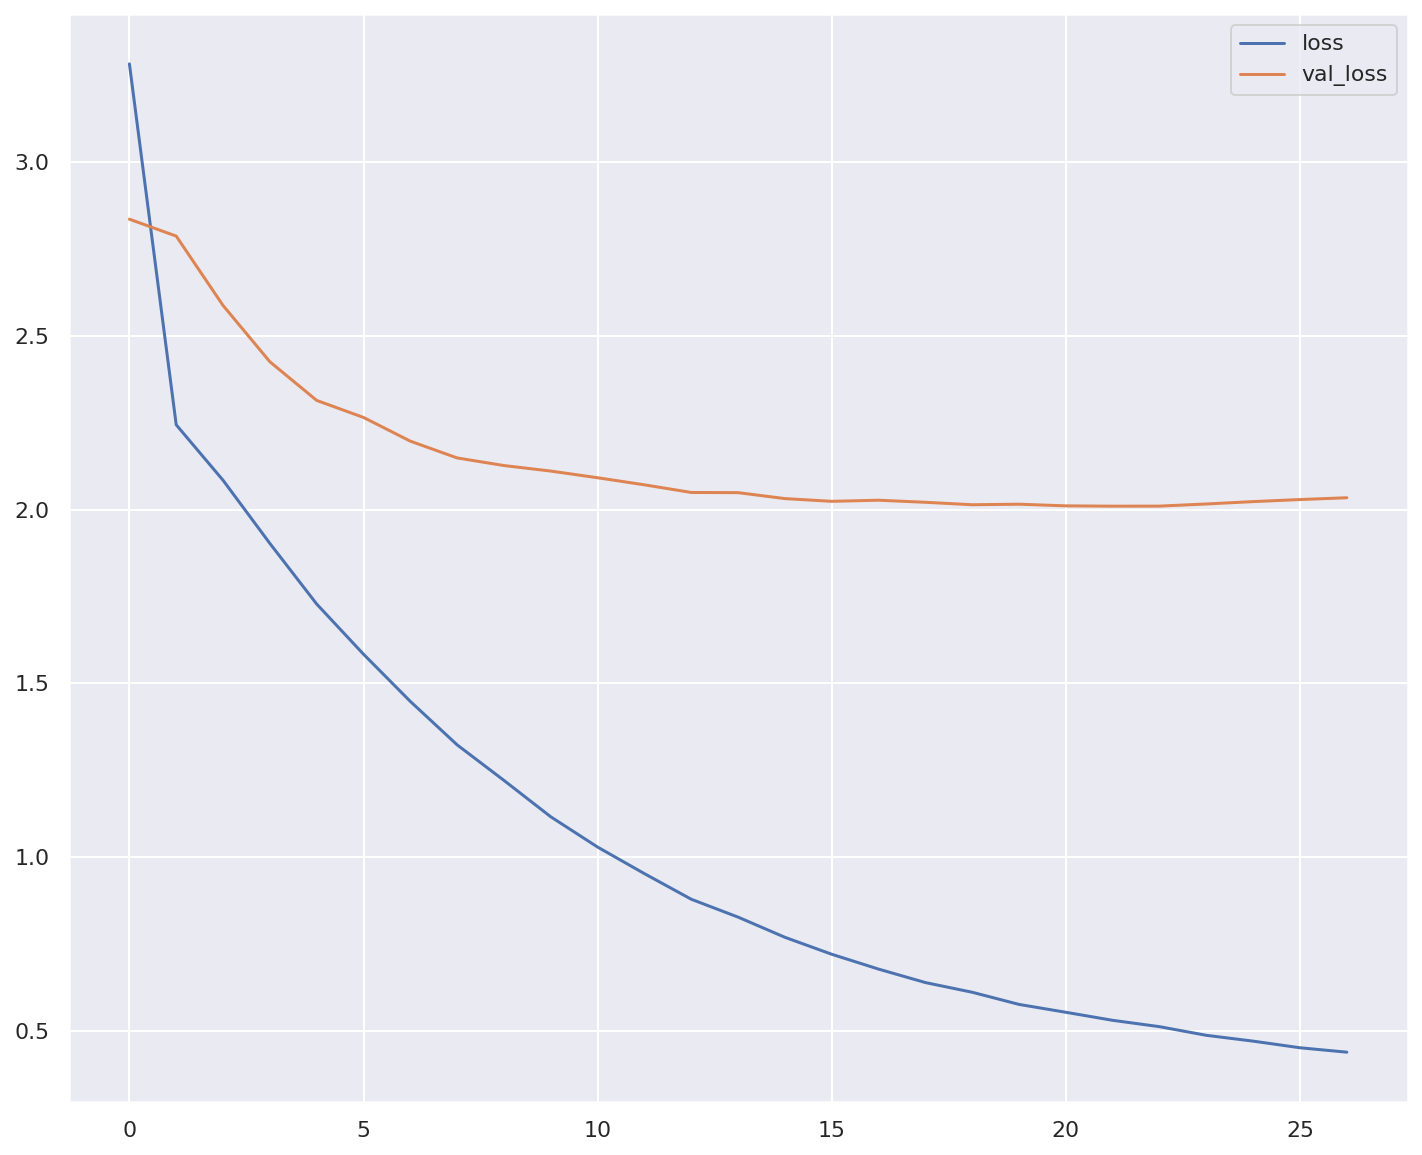

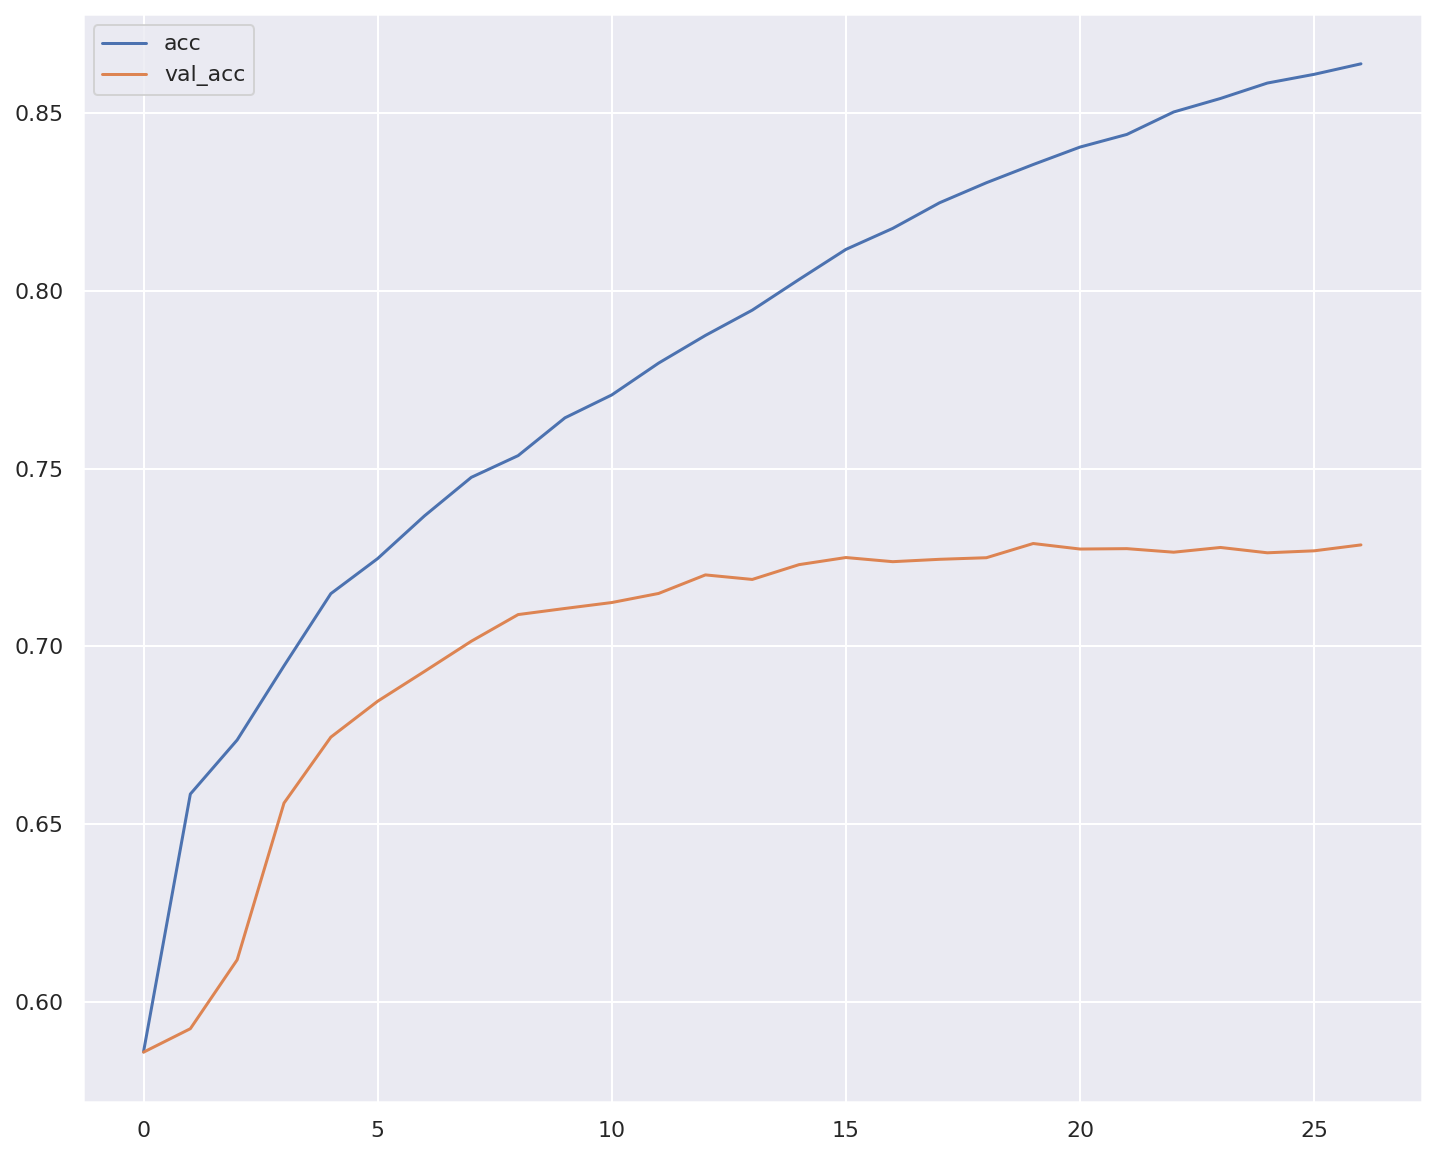

In [37]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set(rc={"figure.figsize":(12,10)})

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()